Analysis of the LFPs in response to photostimulation

This notebook (LFP_Analysis_part2) follows the following pipeline:

1. Selection of an animal
2. Read processed data (LFP_Analysis_part1) from all sessions
3. Selection of an electrode
4. Normalization of the average traces
5. Plot the LFP slope over sessions

The code performs sanity checks and saves plots to illustrate the process


In [1]:
import pickle
import os
import glob
import ntpath
import matplotlib.pylab as plt
import math
import matplotlib
%matplotlib inline
from utils.custom_functions import *
from scipy.signal import find_peaks
import sys
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq

In [11]:
# 1 and 2. Selection of an animal and retrieval of data
AnimalID = 'Red'
GeneralDataDir = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/LFP_Recordings/'
# Load those pickle files that correspond to the animal and that are from Analysis part 1
SessionsAverages = [] # to store the data
SessionsTimes = [] # times associated with the alignment
FileNames = [] # to store experiment names
for file in glob.glob(GeneralDataDir+AnimalID+'*AnalysisPart_1/*.pkl'):
    with open(file, 'rb') as f:
        Interval_Times, Average_Traces = pickle.load(f)
        SessionsAverages.append(Average_Traces)
        SessionsTimes.append(Interval_Times)
    FileNames.append(ntpath.basename(file))
    print('Read {}'.format(ntpath.basename(file)))

# Create output folder to save data
OutPutDir = GeneralDataDir + AnimalID + '_AnalysisPart_2/'
if not os.path.isdir(OutPutDir):
    os.mkdir(OutPutDir)

# Parse titles
FilesDates = parseTitlesForDates(FileNames)


Read Red_2019-04-03_16-51-05_LFP_baseline_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-04_15-05-56_LFP_baseline_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-05_15-49-01_LFP_habituation_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-06_14-47-39_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-07_12-41-59_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-08_11-26-18_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-09_16-29-53_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-10_18-31-30_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-11_17-27-31_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-12_18-01-20_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-13_11-36-29_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-14_14-04-42_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-15_14-04-26_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-16_11-36-49_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-17_11

Progress: [####################] 97.7%


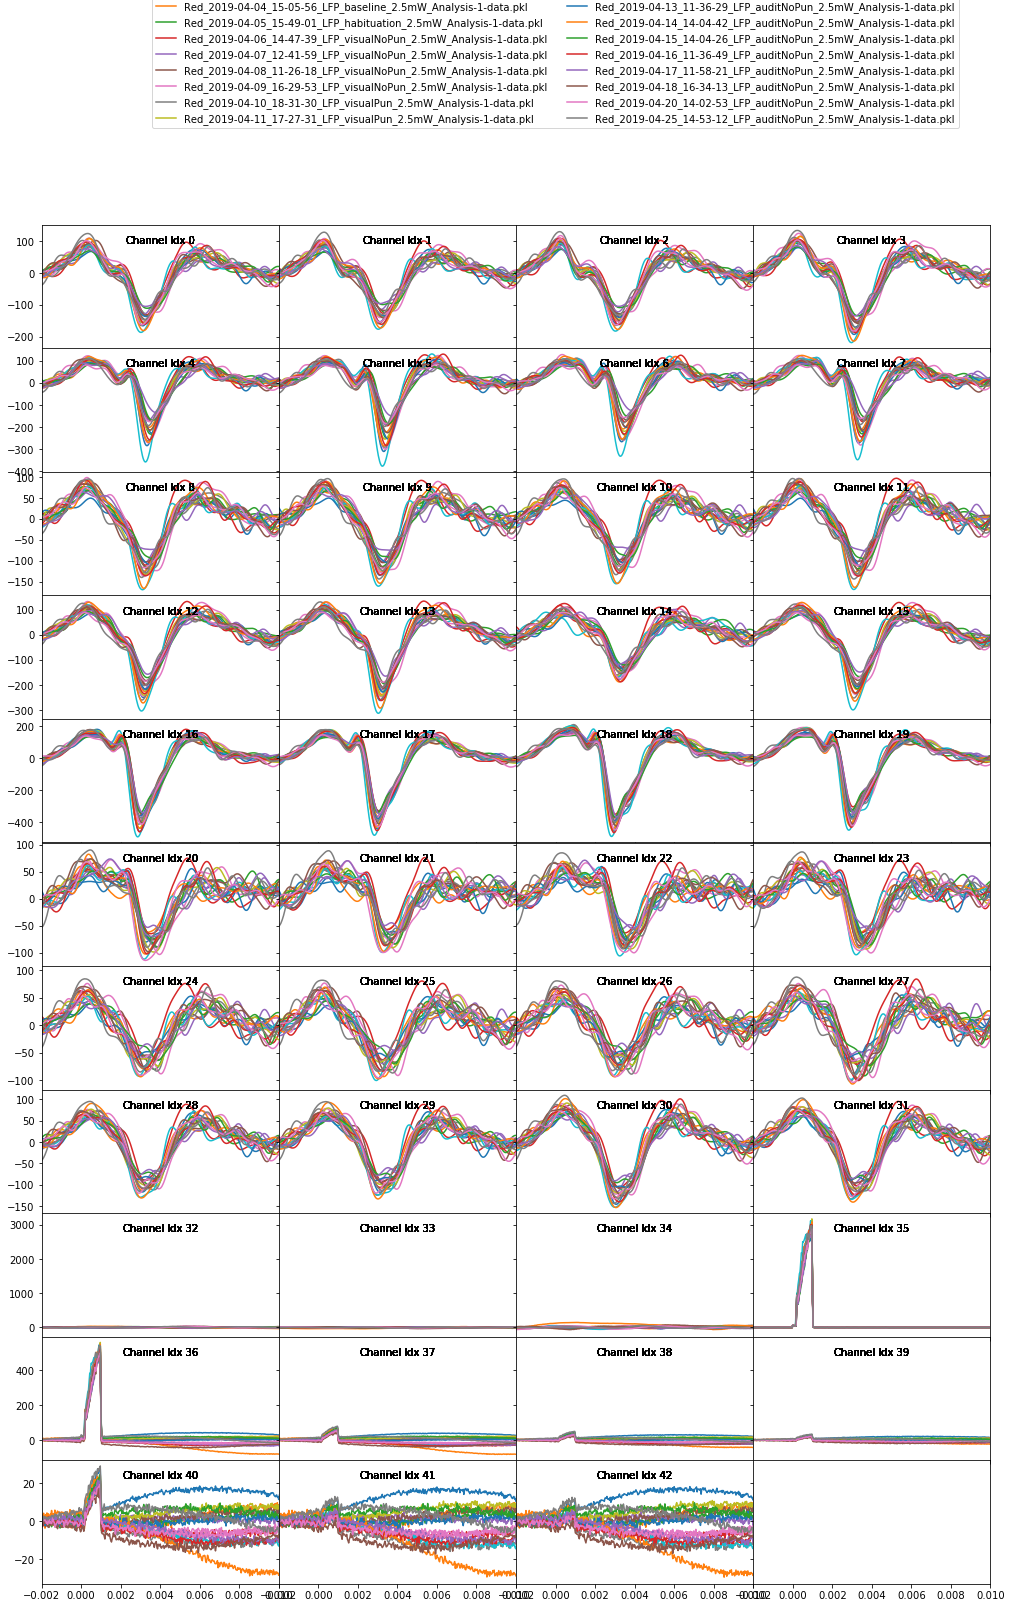

In [12]:
# For each of the channels, plot how the align data looks over experiments
fig, axs = plt.subplots(math.ceil(len(SessionsAverages[0])/4), 4, figsize=(17, 25), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#plt.suptitle(AnimalID, y=0.9, x=0.15)
for j in range(len(SessionsAverages[0])):
    for i in range(len(SessionsAverages)):
        axs[j].plot(SessionsTimes[i], SessionsAverages[i][j], label = FileNames[i])
        axs[j].set_xlim(-0.002, 0.01)
        #axvlines(0, ax=axs[j])
        axs[j].text(.5,.85,"Channel Idx " + str(j), horizontalalignment='center', transform=axs[j].transAxes)
        update_progress(j / len(SessionsAverages[0]))
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.15,0.92), ncol=2)
#plt.show()
fig.savefig(OutPutDir + 'ChannelsSummary.pdf', transparent=True)

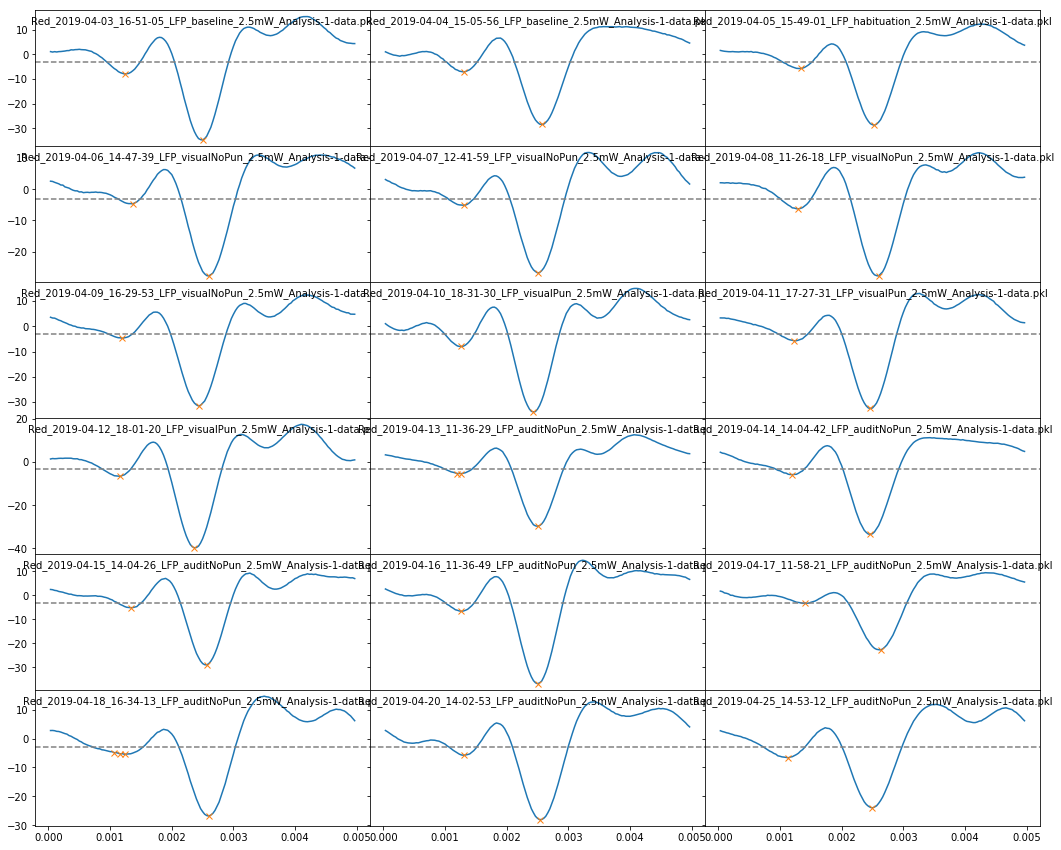

In [20]:
# Now, select an electrode, find the derivative and other features and check correlations
ElectrodeID = 16
# For calculating the height of the peaks
peakThreshold = 3
# define a window of the LFP shape
LFPwindow = [0, 0.005]

# Get the data for the electrode for the LFP frames
ElectrodeLFPData = []
ElectrodeLFPTimes = []
for j in range(len(SessionsAverages)):
    LFPframes = np.logical_and(SessionsTimes[j]>=LFPwindow[0], SessionsTimes[j]<=LFPwindow[1])
    ElectrodeLFPData.append(SessionsAverages[j][ElectrodeID][LFPframes])
    ElectrodeLFPTimes.append(SessionsTimes[j][LFPframes])

Derivatives = np.diff(ElectrodeLFPData, axis = 1)

# find peaks
DerivativePeaks = []
for i in range(len(Derivatives)):
    peaks, _ = find_peaks(-1 * Derivatives[i], height=peakThreshold)
    DerivativePeaks.append(peaks)

    
# find info about minima, etc...    
    
fig, axs = plt.subplots(math.ceil(len(Derivatives)/3), 3, figsize=(18,15), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#plt.suptitle(AnimalID, y=0.9, x=0.15)
for j in range(len(Derivatives)):
    axs[j].plot(ElectrodeLFPTimes[j][:-1], Derivatives[j])
    #peaks, _ = find_peaks(-1 * Derivatives[j], height=peakThreshold)
    peaks = DerivativePeaks[j]
    axs[j].plot(ElectrodeLFPTimes[j][peaks], Derivatives[j][peaks], "x")
    axs[j].axhline(-peakThreshold, color="gray", linestyle = '--')
    #axs[j].set_xlim(0.001, 0.002)
    axs[j].text(.5,.9,FileNames[j], horizontalalignment='center', transform=axs[j].transAxes)

plt.show()

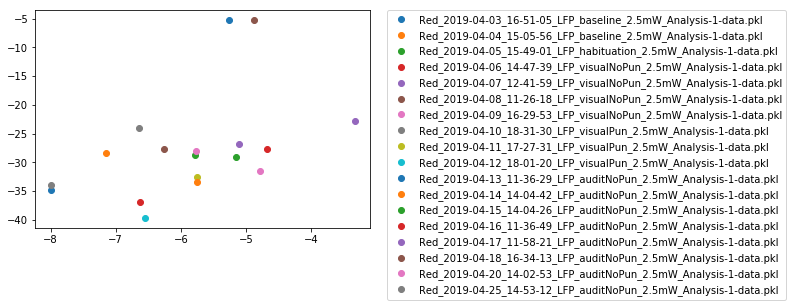

In [21]:
#NOT USED

# plot correlation between peaks
#plt.scatter([x[0] for x in DerivativePeaks], [x[1] for x in DerivativePeaks])
for i in range(len(DerivativePeaks)):
    plt.plot(Derivatives[i][DerivativePeaks[i][0]], Derivatives[i][DerivativePeaks[i][1]], 'o', label = FileNames[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

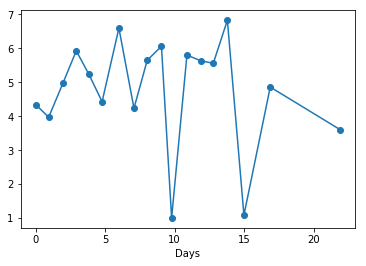

In [22]:
# NOT USED 

# plot relation of peaks across experiments
expTimeDifferences = timeDifferences(FilesDates)
Relation = [Derivatives[i][DerivativePeaks[i][1]] / Derivatives[i][DerivativePeaks[i][0]] for i in range(len(DerivativePeaks))]
plt.plot(expTimeDifferences, Relation, 'o-')
plt.xlabel('Days')

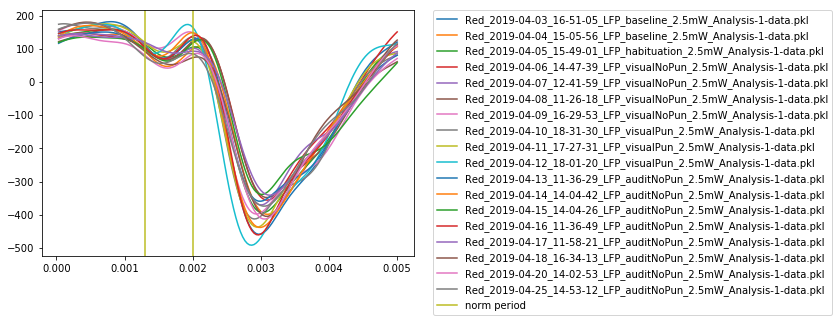

In [23]:
#select a window for normalization to the minima of the ChR2 bump
NormWindow = [0.0013, 0.0020]

#plot the averages overlaped
for j in range(len(ElectrodeLFPData)):
    plt.plot(ElectrodeLFPTimes[j], ElectrodeLFPData[j], label = FileNames[j])
axvlines(NormWindow, label = 'norm period')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xlim(0.00, 0.005)
plt.tight_layout()
#plt.savefig(GeneralDataDir + '000_Results/' + 'Normalized_ChannelIdx_' + str(ElectrodeID) + '.pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

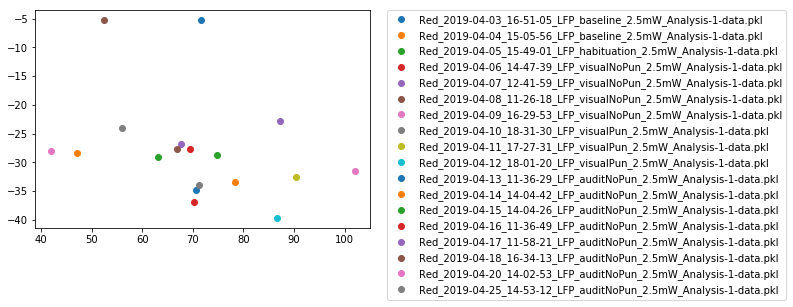

In [24]:
# plot relationship between the minimum of the ChR2 peak and the max slope of the lfp
MinChR2List = []
for j in range(len(ElectrodeLFPData)):
    MinChR2List.append(np.min(ElectrodeLFPData[j][np.logical_and(ElectrodeLFPTimes[j]>=NormWindow[0], ElectrodeLFPTimes[j]<=NormWindow[1])]))   
    
for i in range(len(DerivativePeaks)):
    plt.plot(MinChR2List[i], Derivatives[i][DerivativePeaks[i][1]], 'o', label = FileNames[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

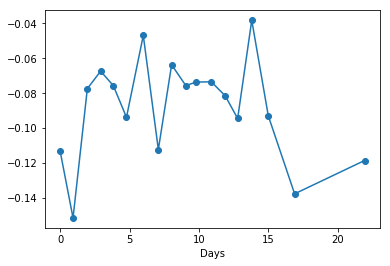

In [25]:
# plot relation of peaks across experiments
expTimeDifferences = timeDifferences(FilesDates)
Relation = [Derivatives[i][DerivativePeaks[i][0]] / MinChR2List[i] for i in range(len(DerivativePeaks))]
plt.plot(expTimeDifferences, Relation, 'o-')
plt.xlabel('Days')

In [10]:
# Normalize the traces
sToSubstract = 0.05
# list to save the averages normalized
SessionsAveragesNormalized = []

#plot the averages overlaped
for j in range(len(ElectrodeData)):
    SessionsAveragesNormalized.append(normalizeTrace(ElectrodeLFPData[j], ElectrodeLFPTimes[j], 30000 * pq.Hz, sToSubstract, NormWindow))
    plt.plot(ElectrodeLFPTimes[j], SessionsAveragesNormalized[j], label = FileNames[j])
axvlines(NormWindow, label = 'norm period')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xlim(0.00, 0.005)
plt.tight_layout()
#plt.savefig(GeneralDataDir + '000_Results/' + 'Normalized_ChannelIdx_' + str(ElectrodeID) + '.pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

NameError: name 'ElectrodeData' is not defined